In [15]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import pandas as pd
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

In [16]:
train = pd.read_parquet('train.parquet')
val = pd.read_parquet('val.parquet')
test = pd.read_parquet('test.parquet')

In [17]:
target = 'cardio'

# FIRST

In [18]:
train_data = lgb.Dataset(train.drop(columns=target), label=train[target])
val_data = lgb.Dataset(val.drop(columns=target), label=val[target], reference=train_data)

params = {
    'objective': 'binary',      
    'boosting_type': 'gbdt',     
    'learning_rate': 0.05,   
    'num_leaves': 31,           
    'max_depth': -1,              
    'verbose': -1,                    
    'random_state': 42
}

model = lgb.train(
    params,
    train_data,
    valid_sets=[val_data],
    num_boost_round=1000
)

Accuracy на тесте: 0.7360
              precision    recall  f1-score   support

           0       0.72      0.78      0.75      6988
           1       0.76      0.70      0.73      7012

    accuracy                           0.74     14000
   macro avg       0.74      0.74      0.74     14000
weighted avg       0.74      0.74      0.74     14000

ROC-AUC Score на тесте: 0.7944


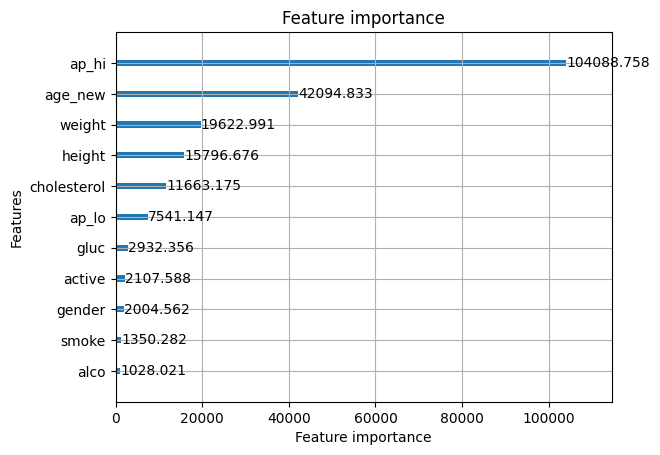

In [19]:
y_pred_prob = model.predict(test.drop(columns=target), num_iteration=model.best_iteration)
y_pred = (y_pred_prob > 0.5).astype(int) 

accuracy = accuracy_score(test[target], y_pred)
print(f'Accuracy на тесте: {accuracy:.4f}')
print(classification_report(test[target], y_pred))

lgb.plot_importance(model, max_num_features=50, importance_type='gain')

y_pred_prob = model.predict(test.drop(columns=target), num_iteration=model.best_iteration)

roc_auc = roc_auc_score(test[target], y_pred_prob)
print(f'ROC-AUC Score на тесте: {roc_auc:.4f}')

# SECOND

In [20]:
train = train.drop(columns=['alco', 'smoke', 'gender', 'active', 'gluc'])
val = val.drop(columns=['alco', 'smoke', 'gender', 'active', 'gluc'])
test = test.drop(columns=['alco', 'smoke', 'gender', 'active', 'gluc'])

In [21]:
train_data = lgb.Dataset(train.drop(columns=target), label=train[target])
val_data = lgb.Dataset(val.drop(columns=target), label=val[target], reference=train_data)


params = {
    'objective': 'binary',         
    'boosting_type': 'gbdt',    
    'learning_rate': 0.05,          
    'num_leaves': 31,               
    'max_depth': -1,               
    'verbose': -1,                   
    'random_state': 42
}

model = lgb.train(
    params,
    train_data,
    valid_sets=[val_data],
    num_boost_round=1000
)

Accuracy на тесте: 0.7306
              precision    recall  f1-score   support

           0       0.71      0.77      0.74      6988
           1       0.75      0.69      0.72      7012

    accuracy                           0.73     14000
   macro avg       0.73      0.73      0.73     14000
weighted avg       0.73      0.73      0.73     14000

ROC-AUC Score на тесте: 0.7901


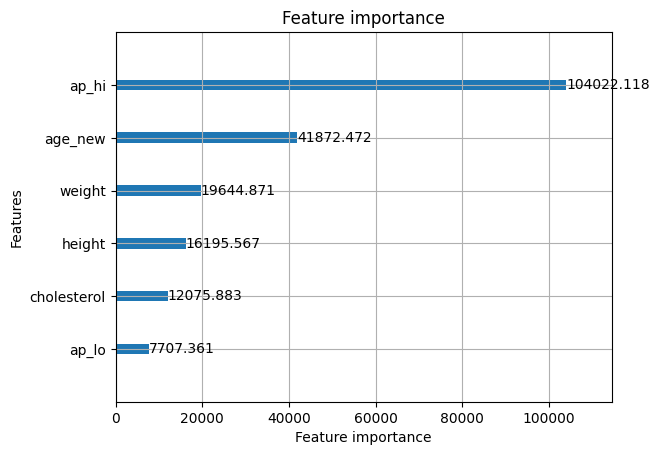

In [22]:
y_pred_prob = model.predict(test.drop(columns=target), num_iteration=model.best_iteration)
y_pred = (y_pred_prob > 0.5).astype(int)  

accuracy = accuracy_score(test[target], y_pred)
print(f'Accuracy на тесте: {accuracy:.4f}')
print(classification_report(test[target], y_pred))

lgb.plot_importance(model, max_num_features=50, importance_type='gain')

y_pred_prob = model.predict(test.drop(columns=target), num_iteration=model.best_iteration)

roc_auc = roc_auc_score(test[target], y_pred_prob)
print(f'ROC-AUC Score на тесте: {roc_auc:.4f}')

In [23]:
roc_auc_train = roc_auc_score(train[target], model.predict(train.drop(columns=target), num_iteration=model.best_iteration))
print(roc_auc_train)

0.8684252643955159


In [24]:
roc_auc_train = roc_auc_score(val[target], model.predict(val.drop(columns=target), num_iteration=model.best_iteration))
print(roc_auc_train)

0.799298074288592


# LAST

In [25]:
import lightgbm as lgb
import optuna

def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'num_leaves': trial.suggest_int('num_leaves', 100, 3000, step=20),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'min_split_gain': trial.suggest_float('min_split_gain', 0, 1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_iterations': trial.suggest_int('num_iterations', 100, 2000),
        'num_boost_round': trial.suggest_int('nub_boost_round', 100, 3000)
    }
    

    train_data = lgb.Dataset(train.drop(columns=target), label=train[target])
    valid_data = lgb.Dataset(val.drop(columns=target), label=val[target], reference=train_data)
    
    model = lgb.train(
        params,
        train_data,
        valid_sets=[valid_data]
    )
    

    train_roc_auc = roc_auc_score(train[target], model.predict(train.drop(columns=target), num_iteration=model.best_iteration))

    test_roc_auc = roc_auc_score(test[target], model.predict(test.drop(columns=target), num_iteration=model.best_iteration))
    
    if train_roc_auc - test_roc_auc > 0.3:
        return 0
    else:
        return test_roc_auc
    

study = optuna.create_study(direction='maximize')

study.optimize(
    objective,
    n_trials=200,
    show_progress_bar=True
)

# Выводим результаты
print("Best trial:")
trial = study.best_trial
print(f"  ROC-AUC: {trial.value:.5f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-04-08 20:21:08,510] A new study created in memory with name: no-name-08e78d12-5fff-4384-a5d7-f40f64219ba3


  0%|          | 0/200 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1671, num_boost_round=2699. LightGBM will perform up to 1671 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:21:11,168] Trial 0 finished with value: 0.7972481286475617 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1400, 'learning_rate': 0.03101652963439105, 'min_child_samples': 186, 'min_split_gain': 0.40884385557160574, 'max_depth': 9, 'num_iterations': 1671, 'nub_boost_round': 2699}. Best is trial 0 with value: 0.7972481286475617.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=884, num_boost_round=2210. LightGBM will perform up to 884 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:21:11,897] Trial 1 finished with value: 0.7992870530068497 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1640, 'learning_rate': 0.06738719913335918, 'min_child_samples': 181, 'min_split_gain': 0.17528381340833887, 'max_depth': 3, 'num_iterations': 884, 'nub_boost_round': 2210}. Best is trial 1 with value: 0.7992870530068497.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=948, num_boost_round=1238. LightGBM will perform up to 948 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:21:21,593] Trial 2 finished with value: 0.7998876262003709 and parameters: {'boosting_type': 'dart', 'num_leaves': 2440, 'learning_rate': 0.06552135625124804, 'min_child_samples': 213, 'min_split_gain': 0.6049021191089999, 'max_depth': 3, 'num_iterations': 948, 'nub_boost_round': 1238}. Best is trial 2 with value: 0.7998876262003709.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=957, num_boost_round=593. LightGBM will perform up to 957 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:21:22,076] Trial 3 finished with value: 0.7990545319153592 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 740, 'learning_rate': 0.13298300865550003, 'min_child_samples': 222, 'min_split_gain': 0.9811979347698165, 'max_depth': 3, 'num_iterations': 957, 'nub_boost_round': 593}. Best is trial 2 with value: 0.7998876262003709.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1920, num_boost_round=2955. LightGBM will perform up to 1920 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:21:23,441] Trial 4 finished with value: 0.799408145199447 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2260, 'learning_rate': 0.01925084459347276, 'min_child_samples': 210, 'min_split_gain': 0.7141810541935072, 'max_depth': 3, 'num_iterations': 1920, 'nub_boost_round': 2955}. Best is trial 2 with value: 0.7998876262003709.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=482, num_boost_round=1672. LightGBM will perform up to 482 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:21:43,374] Trial 5 finished with value: 0.794146639941146 and parameters: {'boosting_type': 'dart', 'num_leaves': 2600, 'learning_rate': 0.05274463624734339, 'min_child_samples': 22, 'min_split_gain': 0.6433139132751006, 'max_depth': 10, 'num_iterations': 482, 'nub_boost_round': 1672}. Best is trial 2 with value: 0.7998876262003709.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1702, num_boost_round=2806. LightGBM will perform up to 1702 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:21:44,543] Trial 6 finished with value: 0.8001796882831657 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2880, 'learning_rate': 0.02527708293195798, 'min_child_samples': 14, 'min_split_gain': 0.9997200350509214, 'max_depth': 3, 'num_iterations': 1702, 'nub_boost_round': 2806}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=989, num_boost_round=584. LightGBM will perform up to 989 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:21:58,997] Trial 7 finished with value: 0.7986586429968284 and parameters: {'boosting_type': 'dart', 'num_leaves': 520, 'learning_rate': 0.020648426743738225, 'min_child_samples': 85, 'min_split_gain': 0.32233797751636784, 'max_depth': 4, 'num_iterations': 989, 'nub_boost_round': 584}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1112, num_boost_round=2363. LightGBM will perform up to 1112 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:22:25,809] Trial 8 finished with value: 0.7964898509089496 and parameters: {'boosting_type': 'dart', 'num_leaves': 1800, 'learning_rate': 0.03941852942954648, 'min_child_samples': 43, 'min_split_gain': 0.291739602494248, 'max_depth': 6, 'num_iterations': 1112, 'nub_boost_round': 2363}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=411, num_boost_round=1014. LightGBM will perform up to 411 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:22:26,127] Trial 9 finished with value: 0.7994369922229975 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 620, 'learning_rate': 0.10057398603381852, 'min_child_samples': 172, 'min_split_gain': 0.3196073378511535, 'max_depth': 3, 'num_iterations': 411, 'nub_boost_round': 1014}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1491, num_boost_round=1863. LightGBM will perform up to 1491 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:22:28,490] Trial 10 finished with value: 0.7983948054867753 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 3000, 'learning_rate': 0.012820843183633293, 'min_child_samples': 287, 'min_split_gain': 0.970262796442678, 'max_depth': 6, 'num_iterations': 1491, 'nub_boost_round': 1863}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1351, num_boost_round=1180. LightGBM will perform up to 1351 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:22:48,916] Trial 11 finished with value: 0.7985742141772825 and parameters: {'boosting_type': 'dart', 'num_leaves': 3000, 'learning_rate': 0.243533372119688, 'min_child_samples': 115, 'min_split_gain': 0.7544495487410685, 'max_depth': 5, 'num_iterations': 1351, 'nub_boost_round': 1180}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=678, num_boost_round=1294. LightGBM will perform up to 678 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:23:08,545] Trial 12 finished with value: 0.7969969544400294 and parameters: {'boosting_type': 'dart', 'num_leaves': 2240, 'learning_rate': 0.010173091467673123, 'min_child_samples': 264, 'min_split_gain': 0.5607802174878803, 'max_depth': 8, 'num_iterations': 678, 'nub_boost_round': 1294}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=191, num_boost_round=2030. LightGBM will perform up to 191 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:23:10,145] Trial 13 finished with value: 0.7969900462564625 and parameters: {'boosting_type': 'dart', 'num_leaves': 2500, 'learning_rate': 0.029083515324483104, 'min_child_samples': 120, 'min_split_gain': 0.009074123578382332, 'max_depth': 5, 'num_iterations': 191, 'nub_boost_round': 2030}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1276, num_boost_round=124. LightGBM will perform up to 1276 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:23:10,978] Trial 14 finished with value: 0.7982303764321267 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1980, 'learning_rate': 0.08118397869974653, 'min_child_samples': 58, 'min_split_gain': 0.8509881139303979, 'max_depth': 5, 'num_iterations': 1276, 'nub_boost_round': 124}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1907, num_boost_round=1478. LightGBM will perform up to 1907 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:23:55,632] Trial 15 finished with value: 0.7978745896722634 and parameters: {'boosting_type': 'dart', 'num_leaves': 1200, 'learning_rate': 0.15701294339572885, 'min_child_samples': 240, 'min_split_gain': 0.5403020315819356, 'max_depth': 7, 'num_iterations': 1907, 'nub_boost_round': 1478}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1647, num_boost_round=2621. LightGBM will perform up to 1647 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:24:22,221] Trial 16 finished with value: 0.7990949401973754 and parameters: {'boosting_type': 'dart', 'num_leaves': 2640, 'learning_rate': 0.048318133843510615, 'min_child_samples': 137, 'min_split_gain': 0.8475346670996754, 'max_depth': 4, 'num_iterations': 1647, 'nub_boost_round': 2621}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=641, num_boost_round=852. LightGBM will perform up to 641 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:24:23,149] Trial 17 finished with value: 0.7997187175407209 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2160, 'learning_rate': 0.021974493163747857, 'min_child_samples': 75, 'min_split_gain': 0.8468310900418328, 'max_depth': 4, 'num_iterations': 641, 'nub_boost_round': 852}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1154, num_boost_round=1748. LightGBM will perform up to 1154 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:25:00,726] Trial 18 finished with value: 0.7933249742611488 and parameters: {'boosting_type': 'dart', 'num_leaves': 2680, 'learning_rate': 0.0374483419200186, 'min_child_samples': 2, 'min_split_gain': 0.44660902604735775, 'max_depth': 7, 'num_iterations': 1154, 'nub_boost_round': 1748}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1681, num_boost_round=2963. LightGBM will perform up to 1681 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:25:02,339] Trial 19 finished with value: 0.7996000641308008 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1000, 'learning_rate': 0.014305808513343144, 'min_child_samples': 99, 'min_split_gain': 0.6600662897386338, 'max_depth': 4, 'num_iterations': 1681, 'nub_boost_round': 2963}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=780, num_boost_round=1490. LightGBM will perform up to 780 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:25:14,375] Trial 20 finished with value: 0.796414064971946 and parameters: {'boosting_type': 'dart', 'num_leaves': 2880, 'learning_rate': 0.2929881453401364, 'min_child_samples': 152, 'min_split_gain': 0.1808345238194845, 'max_depth': 5, 'num_iterations': 780, 'nub_boost_round': 1490}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=591, num_boost_round=847. LightGBM will perform up to 591 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:25:15,178] Trial 21 finished with value: 0.7996673500428245 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 160, 'learning_rate': 0.021384610852525625, 'min_child_samples': 68, 'min_split_gain': 0.885403607615268, 'max_depth': 4, 'num_iterations': 591, 'nub_boost_round': 847}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=314, num_boost_round=532. LightGBM will perform up to 314 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:25:15,662] Trial 22 finished with value: 0.8000923002712498 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2220, 'learning_rate': 0.026791517260891243, 'min_child_samples': 33, 'min_split_gain': 0.890770280274804, 'max_depth': 3, 'num_iterations': 314, 'nub_boost_round': 532}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=193, num_boost_round=307. LightGBM will perform up to 193 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:25:15,983] Trial 23 finished with value: 0.7996204825581528 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2380, 'learning_rate': 0.028443644952945938, 'min_child_samples': 2, 'min_split_gain': 0.7627115231629503, 'max_depth': 3, 'num_iterations': 193, 'nub_boost_round': 307}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=442, num_boost_round=477. LightGBM will perform up to 442 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:25:16,355] Trial 24 finished with value: 0.799899442561627 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1900, 'learning_rate': 0.06657350012755468, 'min_child_samples': 37, 'min_split_gain': 0.9964412513518388, 'max_depth': 3, 'num_iterations': 442, 'nub_boost_round': 477}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=391, num_boost_round=446. LightGBM will perform up to 391 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=105, num_boost_round=189. LightGBM will perform up to 105 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:25:16,885] Trial 25 finished with value: 0.7994342065005251 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1820, 'learning_rate': 0.040845346157308324, 'min_child_samples': 35, 'min_split_gain': 0.9495261633242105, 'max_depth': 4, 'num_iterations': 391, 'nub_boost_round': 446}. Best is trial 6 with value: 0.8001796882831657.
[I 2025-04-08 20:25:17,078] Trial 26 finished with value: 0.7956153993595408 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1980, 'learning_rate': 0.015449210758883567, 'min_child_samples': 26, 'min_split_gain': 0.9145319646333213, 'max_depth': 3, 'num_iterations': 105, 'nub_boost_round': 189}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=298, num_boost_round=691. LightGBM will perform up to 298 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:25:17,582] Trial 27 finished with value: 0.7980322942173543 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1500, 'learning_rate': 0.08535479348244714, 'min_child_samples': 54, 'min_split_gain': 0.8043896137121264, 'max_depth': 6, 'num_iterations': 298, 'nub_boost_round': 691}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=763, num_boost_round=369. LightGBM will perform up to 763 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:25:18,616] Trial 28 finished with value: 0.7988563680676939 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2040, 'learning_rate': 0.026582494109282883, 'min_child_samples': 93, 'min_split_gain': 0.9651099766197782, 'max_depth': 5, 'num_iterations': 763, 'nub_boost_round': 369}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=517, num_boost_round=2528. LightGBM will perform up to 517 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:25:21,180] Trial 29 finished with value: 0.7963331259585743 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1320, 'learning_rate': 0.03423008359078628, 'min_child_samples': 18, 'min_split_gain': 0.9965803699353604, 'max_depth': 9, 'num_iterations': 517, 'nub_boost_round': 2528}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=304, num_boost_round=999. LightGBM will perform up to 304 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:25:21,469] Trial 30 finished with value: 0.7994370840600022 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2740, 'learning_rate': 0.1188533361262097, 'min_child_samples': 47, 'min_split_gain': 0.905151701247813, 'max_depth': 4, 'num_iterations': 304, 'nub_boost_round': 999}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1731, num_boost_round=1249. LightGBM will perform up to 1731 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:25:22,445] Trial 31 finished with value: 0.7999790958569348 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2320, 'learning_rate': 0.0618539775516991, 'min_child_samples': 152, 'min_split_gain': 0.6321525387450656, 'max_depth': 3, 'num_iterations': 1731, 'nub_boost_round': 1249}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1771, num_boost_round=2088. LightGBM will perform up to 1771 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:25:23,420] Trial 32 finished with value: 0.7999503406703888 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1680, 'learning_rate': 0.062324496236396514, 'min_child_samples': 147, 'min_split_gain': 0.7153056910462114, 'max_depth': 3, 'num_iterations': 1771, 'nub_boost_round': 2088}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1792, num_boost_round=2039. LightGBM will perform up to 1792 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:25:24,452] Trial 33 finished with value: 0.7996849725435927 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1660, 'learning_rate': 0.04830784206854345, 'min_child_samples': 161, 'min_split_gain': 0.7021455436535156, 'max_depth': 3, 'num_iterations': 1792, 'nub_boost_round': 2039}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1548, num_boost_round=2213. LightGBM will perform up to 1548 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:25:25,319] Trial 34 finished with value: 0.7995537782804912 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2360, 'learning_rate': 0.0638411172139982, 'min_child_samples': 197, 'min_split_gain': 0.7974696000462471, 'max_depth': 3, 'num_iterations': 1548, 'nub_boost_round': 2213}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1791, num_boost_round=2369. LightGBM will perform up to 1791 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:25:26,293] Trial 35 finished with value: 0.7998334627758906 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1700, 'learning_rate': 0.07980881152907188, 'min_child_samples': 132, 'min_split_gain': 0.6170952811439133, 'max_depth': 3, 'num_iterations': 1791, 'nub_boost_round': 2369}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1427, num_boost_round=2803. LightGBM will perform up to 1427 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:25:27,244] Trial 36 finished with value: 0.7991257872268034 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2140, 'learning_rate': 0.053342222695665055, 'min_child_samples': 184, 'min_split_gain': 0.4690302265503678, 'max_depth': 4, 'num_iterations': 1427, 'nub_boost_round': 2803}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1973, num_boost_round=1359. LightGBM will perform up to 1973 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:25:28,209] Trial 37 finished with value: 0.8000615756911611 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1480, 'learning_rate': 0.16268471346929878, 'min_child_samples': 111, 'min_split_gain': 0.7001473900276949, 'max_depth': 3, 'num_iterations': 1973, 'nub_boost_round': 1359}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1995, num_boost_round=1263. LightGBM will perform up to 1995 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:25:29,224] Trial 38 finished with value: 0.7990577360064078 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1100, 'learning_rate': 0.15556396129440667, 'min_child_samples': 109, 'min_split_gain': 0.3917252050850424, 'max_depth': 4, 'num_iterations': 1995, 'nub_boost_round': 1263}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1899, num_boost_round=1586. LightGBM will perform up to 1899 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:25:30,747] Trial 39 finished with value: 0.7998378607479989 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1420, 'learning_rate': 0.018322530799927544, 'min_child_samples': 76, 'min_split_gain': 0.5728897692271319, 'max_depth': 3, 'num_iterations': 1899, 'nub_boost_round': 1586}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1640, num_boost_round=1380. LightGBM will perform up to 1640 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:25:32,164] Trial 40 finished with value: 0.7929816263133508 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2820, 'learning_rate': 0.1903968871417333, 'min_child_samples': 17, 'min_split_gain': 0.6769842473992815, 'max_depth': 10, 'num_iterations': 1640, 'nub_boost_round': 1380}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1770, num_boost_round=1888. LightGBM will perform up to 1770 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:25:33,080] Trial 41 finished with value: 0.8000100755398138 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2480, 'learning_rate': 0.10709929542766669, 'min_child_samples': 143, 'min_split_gain': 0.7142785888502564, 'max_depth': 3, 'num_iterations': 1770, 'nub_boost_round': 1888}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1562, num_boost_round=1118. LightGBM will perform up to 1562 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:25:33,911] Trial 42 finished with value: 0.7996620439047821 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2500, 'learning_rate': 0.10301705786154491, 'min_child_samples': 171, 'min_split_gain': 0.7755109789846673, 'max_depth': 3, 'num_iterations': 1562, 'nub_boost_round': 1118}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1999, num_boost_round=1781. LightGBM will perform up to 1999 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:25:34,898] Trial 43 finished with value: 0.7999351977687444 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2540, 'learning_rate': 0.17705408226033245, 'min_child_samples': 129, 'min_split_gain': 0.6230975236995953, 'max_depth': 3, 'num_iterations': 1999, 'nub_boost_round': 1781}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1723, num_boost_round=1865. LightGBM will perform up to 1723 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:25:35,828] Trial 44 finished with value: 0.7988466129369849 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2320, 'learning_rate': 0.12306138932543398, 'min_child_samples': 218, 'min_split_gain': 0.5176164854163778, 'max_depth': 4, 'num_iterations': 1723, 'nub_boost_round': 1865}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1851, num_boost_round=763. LightGBM will perform up to 1851 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:25:36,737] Trial 45 finished with value: 0.8000591573167072 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2860, 'learning_rate': 0.22372173456960606, 'min_child_samples': 104, 'min_split_gain': 0.8295117831799954, 'max_depth': 3, 'num_iterations': 1851, 'nub_boost_round': 763}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1847, num_boost_round=725. LightGBM will perform up to 1847 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:25:37,658] Trial 46 finished with value: 0.7993677573256542 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2880, 'learning_rate': 0.2226298601358197, 'min_child_samples': 105, 'min_split_gain': 0.9327966871811835, 'max_depth': 4, 'num_iterations': 1847, 'nub_boost_round': 725}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1206, num_boost_round=977. LightGBM will perform up to 1206 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:25:38,290] Trial 47 finished with value: 0.7996030437313938 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2780, 'learning_rate': 0.24234611634686654, 'min_child_samples': 63, 'min_split_gain': 0.8805225192945138, 'max_depth': 3, 'num_iterations': 1206, 'nub_boost_round': 977}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1389, num_boost_round=599. LightGBM will perform up to 1389 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:25:39,047] Trial 48 finished with value: 0.7985185099319475 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2920, 'learning_rate': 0.2865882772554336, 'min_child_samples': 82, 'min_split_gain': 0.7243380541846947, 'max_depth': 5, 'num_iterations': 1389, 'nub_boost_round': 599}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1867, num_boost_round=2851. LightGBM will perform up to 1867 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:25:40,300] Trial 49 finished with value: 0.7970214749202529 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2620, 'learning_rate': 0.14452511026440004, 'min_child_samples': 119, 'min_split_gain': 0.8367408741621152, 'max_depth': 9, 'num_iterations': 1867, 'nub_boost_round': 2851}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1565, num_boost_round=886. LightGBM will perform up to 1565 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:25:41,207] Trial 50 finished with value: 0.7983738870579539 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 3000, 'learning_rate': 0.20784043773105185, 'min_child_samples': 201, 'min_split_gain': 0.8237922139436017, 'max_depth': 8, 'num_iterations': 1565, 'nub_boost_round': 886}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1947, num_boost_round=1364. LightGBM will perform up to 1947 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:25:42,230] Trial 51 finished with value: 0.7999408508465821 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2440, 'learning_rate': 0.10529007838799687, 'min_child_samples': 145, 'min_split_gain': 0.7554089686062231, 'max_depth': 3, 'num_iterations': 1947, 'nub_boost_round': 1364}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=995, num_boost_round=1103. LightGBM will perform up to 995 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:25:43,190] Trial 52 finished with value: 0.7998825955733421 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2240, 'learning_rate': 0.02413824396764967, 'min_child_samples': 162, 'min_split_gain': 0.590943444988483, 'max_depth': 3, 'num_iterations': 995, 'nub_boost_round': 1103}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1682, num_boost_round=1594. LightGBM will perform up to 1682 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:25:44,019] Trial 53 finished with value: 0.7992378691888402 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 880, 'learning_rate': 0.17455617132521067, 'min_child_samples': 91, 'min_split_gain': 0.6685351562320596, 'max_depth': 4, 'num_iterations': 1682, 'nub_boost_round': 1594}. Best is trial 6 with value: 0.8001796882831657.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1814, num_boost_round=712. LightGBM will perform up to 1814 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:25:45,170] Trial 54 finished with value: 0.8001934944461878 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2700, 'learning_rate': 0.033672287578080815, 'min_child_samples': 120, 'min_split_gain': 0.7294272770026647, 'max_depth': 3, 'num_iterations': 1814, 'nub_boost_round': 712}. Best is trial 54 with value: 0.8001934944461878.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1815, num_boost_round=808. LightGBM will perform up to 1815 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:25:46,432] Trial 55 finished with value: 0.7995912783906955 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2700, 'learning_rate': 0.030782032420366905, 'min_child_samples': 122, 'min_split_gain': 0.8701596565018874, 'max_depth': 4, 'num_iterations': 1815, 'nub_boost_round': 808}. Best is trial 54 with value: 0.8001934944461878.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1474, num_boost_round=588. LightGBM will perform up to 1474 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:26:05,222] Trial 56 finished with value: 0.7993714614181724 and parameters: {'boosting_type': 'dart', 'num_leaves': 2580, 'learning_rate': 0.017117754684777196, 'min_child_samples': 107, 'min_split_gain': 0.7352540749249435, 'max_depth': 3, 'num_iterations': 1474, 'nub_boost_round': 588}. Best is trial 54 with value: 0.8001934944461878.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1317, num_boost_round=471. LightGBM will perform up to 1317 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:26:06,062] Trial 57 finished with value: 0.7991096851386665 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2660, 'learning_rate': 0.042721062323653046, 'min_child_samples': 241, 'min_split_gain': 0.9290220461871841, 'max_depth': 3, 'num_iterations': 1317, 'nub_boost_round': 471}. Best is trial 54 with value: 0.8001934944461878.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1619, num_boost_round=742. LightGBM will perform up to 1619 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:26:07,224] Trial 58 finished with value: 0.7994781045887156 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2860, 'learning_rate': 0.034668986505794225, 'min_child_samples': 141, 'min_split_gain': 0.7928044039767962, 'max_depth': 4, 'num_iterations': 1619, 'nub_boost_round': 742}. Best is trial 54 with value: 0.8001934944461878.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1900, num_boost_round=171. LightGBM will perform up to 1900 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:26:49,445] Trial 59 finished with value: 0.7980102737444781 and parameters: {'boosting_type': 'dart', 'num_leaves': 2440, 'learning_rate': 0.022435997032879698, 'min_child_samples': 10, 'min_split_gain': 0.6866397087709093, 'max_depth': 5, 'num_iterations': 1900, 'nub_boost_round': 171}. Best is trial 54 with value: 0.8001934944461878.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=888, num_boost_round=326. LightGBM will perform up to 888 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:26:49,926] Trial 60 finished with value: 0.7998570342737334 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1300, 'learning_rate': 0.26145444353324354, 'min_child_samples': 32, 'min_split_gain': 0.8858902062246389, 'max_depth': 3, 'num_iterations': 888, 'nub_boost_round': 326}. Best is trial 54 with value: 0.8001934944461878.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1934, num_boost_round=938. LightGBM will perform up to 1934 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:26:51,204] Trial 61 finished with value: 0.7997693197302458 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2140, 'learning_rate': 0.02693995335337836, 'min_child_samples': 157, 'min_split_gain': 0.6569674082459009, 'max_depth': 3, 'num_iterations': 1934, 'nub_boost_round': 938}. Best is trial 54 with value: 0.8001934944461878.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1731, num_boost_round=1140. LightGBM will perform up to 1731 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:26:52,261] Trial 62 finished with value: 0.79959653350818 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2980, 'learning_rate': 0.04496801049964791, 'min_child_samples': 169, 'min_split_gain': 0.6354926046532708, 'max_depth': 3, 'num_iterations': 1731, 'nub_boost_round': 1140}. Best is trial 54 with value: 0.8001934944461878.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1719, num_boost_round=1388. LightGBM will perform up to 1719 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:26:53,370] Trial 63 finished with value: 0.8000701369408106 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2740, 'learning_rate': 0.03350075737772538, 'min_child_samples': 129, 'min_split_gain': 0.8152675402722932, 'max_depth': 3, 'num_iterations': 1719, 'nub_boost_round': 1388}. Best is trial 54 with value: 0.8001934944461878.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1608, num_boost_round=1424. LightGBM will perform up to 1608 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:26:54,659] Trial 64 finished with value: 0.799778636084155 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2820, 'learning_rate': 0.02484352413818327, 'min_child_samples': 128, 'min_split_gain': 0.8178983063624187, 'max_depth': 4, 'num_iterations': 1608, 'nub_boost_round': 1424}. Best is trial 54 with value: 0.8001934944461878.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1844, num_boost_round=1917. LightGBM will perform up to 1844 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:26:55,800] Trial 65 finished with value: 0.8000287694723022 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2760, 'learning_rate': 0.03529213256421725, 'min_child_samples': 97, 'min_split_gain': 0.9519316680910155, 'max_depth': 3, 'num_iterations': 1844, 'nub_boost_round': 1917}. Best is trial 54 with value: 0.8001934944461878.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1836, num_boost_round=2496. LightGBM will perform up to 1836 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:26:57,024] Trial 66 finished with value: 0.7996815745744232 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2680, 'learning_rate': 0.03462723406745469, 'min_child_samples': 98, 'min_split_gain': 0.9565499424495448, 'max_depth': 4, 'num_iterations': 1836, 'nub_boost_round': 2496}. Best is trial 54 with value: 0.8001934944461878.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1953, num_boost_round=1723. LightGBM will perform up to 1953 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:26:58,272] Trial 67 finished with value: 0.800102371729419 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2720, 'learning_rate': 0.030385495790065876, 'min_child_samples': 71, 'min_split_gain': 0.9045368011301427, 'max_depth': 3, 'num_iterations': 1953, 'nub_boost_round': 1723}. Best is trial 54 with value: 0.8001934944461878.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1925, num_boost_round=634. LightGBM will perform up to 1925 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:27:22,931] Trial 68 finished with value: 0.7998570036613983 and parameters: {'boosting_type': 'dart', 'num_leaves': 1540, 'learning_rate': 0.030999294602343515, 'min_child_samples': 46, 'min_split_gain': 0.8622842881783513, 'max_depth': 3, 'num_iterations': 1925, 'nub_boost_round': 634}. Best is trial 54 with value: 0.8001934944461878.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1979, num_boost_round=1679. LightGBM will perform up to 1979 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:27:24,590] Trial 69 finished with value: 0.7994711964051486 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2920, 'learning_rate': 0.02032273513329231, 'min_child_samples': 58, 'min_split_gain': 0.9080524098591148, 'max_depth': 4, 'num_iterations': 1979, 'nub_boost_round': 1679}. Best is trial 54 with value: 0.8001934944461878.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1699, num_boost_round=2209. LightGBM will perform up to 1699 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:27:28,227] Trial 70 finished with value: 0.7978129772463005 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2580, 'learning_rate': 0.01306922715758495, 'min_child_samples': 84, 'min_split_gain': 0.9864467101243232, 'max_depth': 7, 'num_iterations': 1699, 'nub_boost_round': 2209}. Best is trial 54 with value: 0.8001934944461878.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1858, num_boost_round=1509. LightGBM will perform up to 1858 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:27:29,363] Trial 71 finished with value: 0.8001443514446246 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2740, 'learning_rate': 0.03791240197203927, 'min_child_samples': 72, 'min_split_gain': 0.9535332167960202, 'max_depth': 3, 'num_iterations': 1858, 'nub_boost_round': 1509}. Best is trial 54 with value: 0.8001934944461878.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1897, num_boost_round=1536. LightGBM will perform up to 1897 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:27:30,539] Trial 72 finished with value: 0.7999918612005716 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2740, 'learning_rate': 0.03872529012574217, 'min_child_samples': 72, 'min_split_gain': 0.8987101090268876, 'max_depth': 3, 'num_iterations': 1897, 'nub_boost_round': 1536}. Best is trial 54 with value: 0.8001934944461878.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1781, num_boost_round=1312. LightGBM will perform up to 1781 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:27:32,795] Trial 73 finished with value: 0.7990830626114492 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2940, 'learning_rate': 0.028363952052819448, 'min_child_samples': 113, 'min_split_gain': 0.013853632329921317, 'max_depth': 3, 'num_iterations': 1781, 'nub_boost_round': 1312}. Best is trial 54 with value: 0.8001934944461878.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1095, num_boost_round=510. LightGBM will perform up to 1095 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:27:33,747] Trial 74 finished with value: 0.8000592797660465 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1780, 'learning_rate': 0.02421180606059339, 'min_child_samples': 53, 'min_split_gain': 0.7739999642425203, 'max_depth': 3, 'num_iterations': 1095, 'nub_boost_round': 510}. Best is trial 54 with value: 0.8001934944461878.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1123, num_boost_round=522. LightGBM will perform up to 1123 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:27:34,735] Trial 75 finished with value: 0.8000428715545613 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1760, 'learning_rate': 0.023045524162191133, 'min_child_samples': 53, 'min_split_gain': 0.778628419249234, 'max_depth': 3, 'num_iterations': 1123, 'nub_boost_round': 522}. Best is trial 54 with value: 0.8001934944461878.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=722, num_boost_round=403. LightGBM will perform up to 722 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:27:35,610] Trial 76 finished with value: 0.7995994824964384 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1940, 'learning_rate': 0.025986036979486152, 'min_child_samples': 28, 'min_split_gain': 0.9233563424072972, 'max_depth': 4, 'num_iterations': 722, 'nub_boost_round': 403}. Best is trial 54 with value: 0.8001934944461878.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1227, num_boost_round=1765. LightGBM will perform up to 1227 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:27:36,509] Trial 77 finished with value: 0.8000921370054638 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1420, 'learning_rate': 0.03232588366786777, 'min_child_samples': 41, 'min_split_gain': 0.9787503392806894, 'max_depth': 3, 'num_iterations': 1227, 'nub_boost_round': 1765}. Best is trial 54 with value: 0.8001934944461878.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1508, num_boost_round=1720. LightGBM will perform up to 1508 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:27:37,425] Trial 78 finished with value: 0.8003094947870868 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1460, 'learning_rate': 0.04916035456695117, 'min_child_samples': 15, 'min_split_gain': 0.9718178293295661, 'max_depth': 3, 'num_iterations': 1508, 'nub_boost_round': 1720}. Best is trial 78 with value: 0.8003094947870868.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1508, num_boost_round=1741. LightGBM will perform up to 1508 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:27:38,400] Trial 79 finished with value: 0.7994042778411431 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1220, 'learning_rate': 0.04760930427508567, 'min_child_samples': 39, 'min_split_gain': 0.9696813366011486, 'max_depth': 4, 'num_iterations': 1508, 'nub_boost_round': 1741}. Best is trial 78 with value: 0.8003094947870868.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1407, num_boost_round=1948. LightGBM will perform up to 1407 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:28:11,631] Trial 80 finished with value: 0.7975183641356007 and parameters: {'boosting_type': 'dart', 'num_leaves': 1580, 'learning_rate': 0.05564710375557707, 'min_child_samples': 9, 'min_split_gain': 0.9998384584887865, 'max_depth': 6, 'num_iterations': 1407, 'nub_boost_round': 1948}. Best is trial 78 with value: 0.8003094947870868.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1739, num_boost_round=1653. LightGBM will perform up to 1739 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:28:12,802] Trial 81 finished with value: 0.8001813005328016 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1440, 'learning_rate': 0.03165298539019531, 'min_child_samples': 17, 'min_split_gain': 0.943230673391986, 'max_depth': 3, 'num_iterations': 1739, 'nub_boost_round': 1653}. Best is trial 78 with value: 0.8003094947870868.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1256, num_boost_round=1657. LightGBM will perform up to 1256 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:28:13,846] Trial 82 finished with value: 0.8000405756294466 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1360, 'learning_rate': 0.032261707744694376, 'min_child_samples': 19, 'min_split_gain': 0.9344962884516801, 'max_depth': 3, 'num_iterations': 1256, 'nub_boost_round': 1657}. Best is trial 78 with value: 0.8003094947870868.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1743, num_boost_round=1800. LightGBM will perform up to 1743 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:28:14,996] Trial 83 finished with value: 0.8000493511654402 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1420, 'learning_rate': 0.03785380890449944, 'min_child_samples': 25, 'min_split_gain': 0.9782735320070821, 'max_depth': 3, 'num_iterations': 1743, 'nub_boost_round': 1800}. Best is trial 78 with value: 0.8003094947870868.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1661, num_boost_round=1492. LightGBM will perform up to 1661 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:28:16,025] Trial 84 finished with value: 0.8002925253494623 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1200, 'learning_rate': 0.042876060364919644, 'min_child_samples': 1, 'min_split_gain': 0.8602384453747229, 'max_depth': 3, 'num_iterations': 1661, 'nub_boost_round': 1492}. Best is trial 78 with value: 0.8003094947870868.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1603, num_boost_round=1481. LightGBM will perform up to 1603 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:28:17,294] Trial 85 finished with value: 0.8002987498575506 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1140, 'learning_rate': 0.04083285603497461, 'min_child_samples': 9, 'min_split_gain': 0.952737031350258, 'max_depth': 3, 'num_iterations': 1603, 'nub_boost_round': 1481}. Best is trial 78 with value: 0.8003094947870868.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1657, num_boost_round=1484. LightGBM will perform up to 1657 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:28:18,456] Trial 86 finished with value: 0.8002820763391632 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1160, 'learning_rate': 0.05765506937102354, 'min_child_samples': 7, 'min_split_gain': 0.8586192739074388, 'max_depth': 3, 'num_iterations': 1657, 'nub_boost_round': 1484}. Best is trial 78 with value: 0.8003094947870868.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1643, num_boost_round=1497. LightGBM will perform up to 1643 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:28:19,533] Trial 87 finished with value: 0.7993829512478567 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 920, 'learning_rate': 0.05834541112352189, 'min_child_samples': 11, 'min_split_gain': 0.9438559466722775, 'max_depth': 4, 'num_iterations': 1643, 'nub_boost_round': 1497}. Best is trial 78 with value: 0.8003094947870868.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1596, num_boost_round=1634. LightGBM will perform up to 1596 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:28:20,554] Trial 88 finished with value: 0.8002572089191445 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1120, 'learning_rate': 0.04129072217032652, 'min_child_samples': 9, 'min_split_gain': 0.9067209628583769, 'max_depth': 3, 'num_iterations': 1596, 'nub_boost_round': 1634}. Best is trial 78 with value: 0.8003094947870868.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1589, num_boost_round=1606. LightGBM will perform up to 1589 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:28:21,466] Trial 89 finished with value: 0.800201708756042 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1140, 'learning_rate': 0.07618797568529904, 'min_child_samples': 1, 'min_split_gain': 0.867661537817599, 'max_depth': 3, 'num_iterations': 1589, 'nub_boost_round': 1606}. Best is trial 78 with value: 0.8003094947870868.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1468, num_boost_round=1633. LightGBM will perform up to 1468 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:28:22,437] Trial 90 finished with value: 0.8001957291466326 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1120, 'learning_rate': 0.0433567122471903, 'min_child_samples': 2, 'min_split_gain': 0.8566772278240984, 'max_depth': 3, 'num_iterations': 1468, 'nub_boost_round': 1633}. Best is trial 78 with value: 0.8003094947870868.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1456, num_boost_round=1567. LightGBM will perform up to 1456 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:28:23,336] Trial 91 finished with value: 0.8001751984740527 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1080, 'learning_rate': 0.05104536171666516, 'min_child_samples': 2, 'min_split_gain': 0.8559907745751405, 'max_depth': 3, 'num_iterations': 1456, 'nub_boost_round': 1567}. Best is trial 78 with value: 0.8003094947870868.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1527, num_boost_round=1627. LightGBM will perform up to 1527 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:28:24,204] Trial 92 finished with value: 0.8000923921082543 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1200, 'learning_rate': 0.0759722313764733, 'min_child_samples': 11, 'min_split_gain': 0.869412815883488, 'max_depth': 3, 'num_iterations': 1527, 'nub_boost_round': 1627}. Best is trial 78 with value: 0.8003094947870868.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1574, num_boost_round=1217. LightGBM will perform up to 1574 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:28:25,124] Trial 93 finished with value: 0.8001180146325328 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 760, 'learning_rate': 0.04404079108654658, 'min_child_samples': 2, 'min_split_gain': 0.912750713128303, 'max_depth': 3, 'num_iterations': 1574, 'nub_boost_round': 1217}. Best is trial 78 with value: 0.8003094947870868.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1606, num_boost_round=1456. LightGBM will perform up to 1606 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:28:26,087] Trial 94 finished with value: 0.7992845938159491 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1120, 'learning_rate': 0.07156270362535215, 'min_child_samples': 17, 'min_split_gain': 0.8495458231081774, 'max_depth': 4, 'num_iterations': 1606, 'nub_boost_round': 1456}. Best is trial 78 with value: 0.8003094947870868.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1665, num_boost_round=1979. LightGBM will perform up to 1665 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:28:26,975] Trial 95 finished with value: 0.8001085044005027 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1000, 'learning_rate': 0.08795925697122531, 'min_child_samples': 24, 'min_split_gain': 0.8891354062058872, 'max_depth': 3, 'num_iterations': 1665, 'nub_boost_round': 1979}. Best is trial 78 with value: 0.8003094947870868.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1360, num_boost_round=1829. LightGBM will perform up to 1360 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:28:28,020] Trial 96 finished with value: 0.8001200860671916 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1240, 'learning_rate': 0.0408232918408092, 'min_child_samples': 7, 'min_split_gain': 0.9191144211101452, 'max_depth': 3, 'num_iterations': 1360, 'nub_boost_round': 1829}. Best is trial 78 with value: 0.8003094947870868.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1445, num_boost_round=1679. LightGBM will perform up to 1445 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:28:28,933] Trial 97 finished with value: 0.7999115038215623 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1140, 'learning_rate': 0.04967321433369246, 'min_child_samples': 30, 'min_split_gain': 0.8371548497522916, 'max_depth': 3, 'num_iterations': 1445, 'nub_boost_round': 1679}. Best is trial 78 with value: 0.8003094947870868.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1579, num_boost_round=1440. LightGBM will perform up to 1579 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:28:29,808] Trial 98 finished with value: 0.8001477085973479 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1000, 'learning_rate': 0.059463564252850695, 'min_child_samples': 14, 'min_split_gain': 0.9666905981920199, 'max_depth': 3, 'num_iterations': 1579, 'nub_boost_round': 1440}. Best is trial 78 with value: 0.8003094947870868.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1519, num_boost_round=2130. LightGBM will perform up to 1519 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:28:30,896] Trial 99 finished with value: 0.7995949110544325 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1280, 'learning_rate': 0.044817915627101614, 'min_child_samples': 22, 'min_split_gain': 0.8783034835068401, 'max_depth': 4, 'num_iterations': 1519, 'nub_boost_round': 2130}. Best is trial 78 with value: 0.8003094947870868.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1670, num_boost_round=1586. LightGBM will perform up to 1670 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:28:50,530] Trial 100 finished with value: 0.7992562672020913 and parameters: {'boosting_type': 'dart', 'num_leaves': 880, 'learning_rate': 0.06930286131321489, 'min_child_samples': 5, 'min_split_gain': 0.8058514698124215, 'max_depth': 3, 'num_iterations': 1670, 'nub_boost_round': 1586}. Best is trial 78 with value: 0.8003094947870868.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1442, num_boost_round=1302. LightGBM will perform up to 1442 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:28:51,456] Trial 101 finished with value: 0.8001651270158835 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1160, 'learning_rate': 0.05256495860413007, 'min_child_samples': 2, 'min_split_gain': 0.8609845528246767, 'max_depth': 3, 'num_iterations': 1442, 'nub_boost_round': 1302}. Best is trial 78 with value: 0.8003094947870868.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1470, num_boost_round=1584. LightGBM will perform up to 1470 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:28:52,364] Trial 102 finished with value: 0.8000683410171654 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1060, 'learning_rate': 0.05040399856726504, 'min_child_samples': 16, 'min_split_gain': 0.9405293369456196, 'max_depth': 3, 'num_iterations': 1470, 'nub_boost_round': 1584}. Best is trial 78 with value: 0.8003094947870868.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1486, num_boost_round=1532. LightGBM will perform up to 1486 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:28:53,516] Trial 103 finished with value: 0.8000505348423881 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1060, 'learning_rate': 0.04233695199701925, 'min_child_samples': 33, 'min_split_gain': 0.8379726321447313, 'max_depth': 3, 'num_iterations': 1486, 'nub_boost_round': 1532}. Best is trial 78 with value: 0.8003094947870868.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1606, num_boost_round=2651. LightGBM will perform up to 1606 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:28:54,431] Trial 104 finished with value: 0.8002411884639007 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 400, 'learning_rate': 0.055267287540883586, 'min_child_samples': 2, 'min_split_gain': 0.8993292694789627, 'max_depth': 3, 'num_iterations': 1606, 'nub_boost_round': 2651}. Best is trial 78 with value: 0.8003094947870868.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1646, num_boost_round=2724. LightGBM will perform up to 1646 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:28:55,494] Trial 105 finished with value: 0.8000364225560174 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 340, 'learning_rate': 0.04670732918888579, 'min_child_samples': 21, 'min_split_gain': 0.9006196327322463, 'max_depth': 3, 'num_iterations': 1646, 'nub_boost_round': 2724}. Best is trial 78 with value: 0.8003094947870868.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1542, num_boost_round=2533. LightGBM will perform up to 1542 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:28:56,379] Trial 106 finished with value: 0.7992214915896896 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 700, 'learning_rate': 0.03676716043384388, 'min_child_samples': 298, 'min_split_gain': 0.997311063391148, 'max_depth': 3, 'num_iterations': 1542, 'nub_boost_round': 2533}. Best is trial 78 with value: 0.8003094947870868.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1605, num_boost_round=2856. LightGBM will perform up to 1605 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:28:57,312] Trial 107 finished with value: 0.7994393085563354 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 480, 'learning_rate': 0.05602157527385868, 'min_child_samples': 8, 'min_split_gain': 0.921459748869179, 'max_depth': 4, 'num_iterations': 1605, 'nub_boost_round': 2856}. Best is trial 78 with value: 0.8003094947870868.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1697, num_boost_round=2948. LightGBM will perform up to 1697 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:28:58,361] Trial 108 finished with value: 0.8000276266118006 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1360, 'learning_rate': 0.06410651733625067, 'min_child_samples': 14, 'min_split_gain': 0.3839221658633335, 'max_depth': 3, 'num_iterations': 1697, 'nub_boost_round': 2948}. Best is trial 78 with value: 0.8003094947870868.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1805, num_boost_round=2712. LightGBM will perform up to 1805 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:28:59,525] Trial 109 finished with value: 0.7997814932354086 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1480, 'learning_rate': 0.041074956913542716, 'min_child_samples': 36, 'min_split_gain': 0.9652789683342857, 'max_depth': 3, 'num_iterations': 1805, 'nub_boost_round': 2712}. Best is trial 78 with value: 0.8003094947870868.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1759, num_boost_round=2288. LightGBM will perform up to 1759 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:29:02,369] Trial 110 finished with value: 0.7956826036386718 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 140, 'learning_rate': 0.029011612757955028, 'min_child_samples': 1, 'min_split_gain': 0.7385100525309514, 'max_depth': 8, 'num_iterations': 1759, 'nub_boost_round': 2288}. Best is trial 78 with value: 0.8003094947870868.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1354, num_boost_round=2626. LightGBM will perform up to 1354 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:29:03,201] Trial 111 finished with value: 0.80014570859147 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 820, 'learning_rate': 0.051568604619601825, 'min_child_samples': 5, 'min_split_gain': 0.8481708681094007, 'max_depth': 3, 'num_iterations': 1354, 'nub_boost_round': 2626}. Best is trial 78 with value: 0.8003094947870868.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1591, num_boost_round=1713. LightGBM will perform up to 1591 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:29:03,994] Trial 112 finished with value: 0.8002567497341216 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 980, 'learning_rate': 0.09359895578617361, 'min_child_samples': 26, 'min_split_gain': 0.884705466594966, 'max_depth': 3, 'num_iterations': 1591, 'nub_boost_round': 1713}. Best is trial 78 with value: 0.8003094947870868.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1601, num_boost_round=1687. LightGBM will perform up to 1601 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:29:04,859] Trial 113 finished with value: 0.8001850658499895 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1280, 'learning_rate': 0.08497440556584962, 'min_child_samples': 26, 'min_split_gain': 0.885697150656989, 'max_depth': 3, 'num_iterations': 1601, 'nub_boost_round': 1687}. Best is trial 78 with value: 0.8003094947870868.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1583, num_boost_round=1717. LightGBM will perform up to 1583 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:29:05,705] Trial 114 finished with value: 0.8000825961610989 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1300, 'learning_rate': 0.08887710476648474, 'min_child_samples': 27, 'min_split_gain': 0.888958548116853, 'max_depth': 3, 'num_iterations': 1583, 'nub_boost_round': 1717}. Best is trial 78 with value: 0.8003094947870868.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1629, num_boost_round=1830. LightGBM will perform up to 1629 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:29:06,551] Trial 115 finished with value: 0.8000983309012173 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 980, 'learning_rate': 0.09683514496619847, 'min_child_samples': 21, 'min_split_gain': 0.7960867086112156, 'max_depth': 3, 'num_iterations': 1629, 'nub_boost_round': 1830}. Best is trial 78 with value: 0.8003094947870868.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1534, num_boost_round=1654. LightGBM will perform up to 1534 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:29:07,457] Trial 116 finished with value: 0.8001979944594122 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1260, 'learning_rate': 0.07542030671616527, 'min_child_samples': 13, 'min_split_gain': 0.8767048956754315, 'max_depth': 3, 'num_iterations': 1534, 'nub_boost_round': 1654}. Best is trial 78 with value: 0.8003094947870868.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1526, num_boost_round=1061. LightGBM will perform up to 1526 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:29:08,393] Trial 117 finished with value: 0.7992257467042352 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1180, 'learning_rate': 0.07431253192170262, 'min_child_samples': 45, 'min_split_gain': 0.8211657220082706, 'max_depth': 4, 'num_iterations': 1526, 'nub_boost_round': 1061}. Best is trial 78 with value: 0.8003094947870868.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1492, num_boost_round=2006. LightGBM will perform up to 1492 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:29:09,260] Trial 118 finished with value: 0.8002180659469693 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1260, 'learning_rate': 0.06728553929754275, 'min_child_samples': 13, 'min_split_gain': 0.8693017325990321, 'max_depth': 3, 'num_iterations': 1492, 'nub_boost_round': 2006}. Best is trial 78 with value: 0.8003094947870868.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1401, num_boost_round=1402. LightGBM will perform up to 1401 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:29:11,716] Trial 119 finished with value: 0.7935015053921791 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1580, 'learning_rate': 0.0666933669645006, 'min_child_samples': 8, 'min_split_gain': 0.8673202904629047, 'max_depth': 10, 'num_iterations': 1401, 'nub_boost_round': 1402}. Best is trial 78 with value: 0.8003094947870868.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1306, num_boost_round=1858. LightGBM will perform up to 1306 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:29:12,405] Trial 120 finished with value: 0.8004287400354809 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 940, 'learning_rate': 0.1148210693846724, 'min_child_samples': 14, 'min_split_gain': 0.8287961758591819, 'max_depth': 3, 'num_iterations': 1306, 'nub_boost_round': 1858}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1307, num_boost_round=2034. LightGBM will perform up to 1307 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:29:13,099] Trial 121 finished with value: 0.8002147496106928 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 940, 'learning_rate': 0.11718223423638872, 'min_child_samples': 13, 'min_split_gain': 0.8294827824450496, 'max_depth': 3, 'num_iterations': 1307, 'nub_boost_round': 2034}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1487, num_boost_round=1979. LightGBM will perform up to 1487 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:29:13,859] Trial 122 finished with value: 0.7998284831694199 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 940, 'learning_rate': 0.118628075344762, 'min_child_samples': 12, 'min_split_gain': 0.8296993112872236, 'max_depth': 3, 'num_iterations': 1487, 'nub_boost_round': 1979}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1302, num_boost_round=1859. LightGBM will perform up to 1302 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:29:14,545] Trial 123 finished with value: 0.7999610039670321 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 580, 'learning_rate': 0.1116249081251673, 'min_child_samples': 14, 'min_split_gain': 0.7859276896581954, 'max_depth': 3, 'num_iterations': 1302, 'nub_boost_round': 1859}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1553, num_boost_round=2126. LightGBM will perform up to 1553 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:29:15,565] Trial 124 finished with value: 0.7997451768021522 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1040, 'learning_rate': 0.09261863055273703, 'min_child_samples': 8, 'min_split_gain': 0.2097635626349107, 'max_depth': 3, 'num_iterations': 1553, 'nub_boost_round': 2126}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1424, num_boost_round=2040. LightGBM will perform up to 1424 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:29:16,328] Trial 125 finished with value: 0.8003365356828804 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1240, 'learning_rate': 0.1339128643590624, 'min_child_samples': 1, 'min_split_gain': 0.8704780400677695, 'max_depth': 3, 'num_iterations': 1424, 'nub_boost_round': 2040}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1184, num_boost_round=1777. LightGBM will perform up to 1184 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:29:29,001] Trial 126 finished with value: 0.799403206409423 and parameters: {'boosting_type': 'dart', 'num_leaves': 1220, 'learning_rate': 0.12427905120042824, 'min_child_samples': 32, 'min_split_gain': 0.9054223377236382, 'max_depth': 3, 'num_iterations': 1184, 'nub_boost_round': 1777}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1301, num_boost_round=2060. LightGBM will perform up to 1301 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:29:29,680] Trial 127 finished with value: 0.800085524741134 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1360, 'learning_rate': 0.1375430726337978, 'min_child_samples': 20, 'min_split_gain': 0.7623989733334589, 'max_depth': 3, 'num_iterations': 1301, 'nub_boost_round': 2060}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1373, num_boost_round=1994. LightGBM will perform up to 1373 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:29:30,445] Trial 128 finished with value: 0.7995135332642611 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 820, 'learning_rate': 0.08040674236191325, 'min_child_samples': 13, 'min_split_gain': 0.808167608310806, 'max_depth': 4, 'num_iterations': 1373, 'nub_boost_round': 1994}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1423, num_boost_round=1892. LightGBM will perform up to 1423 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:29:31,200] Trial 129 finished with value: 0.7998574118258632 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1240, 'learning_rate': 0.0963083509423108, 'min_child_samples': 38, 'min_split_gain': 0.9279574826444936, 'max_depth': 3, 'num_iterations': 1423, 'nub_boost_round': 1892}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1510, num_boost_round=2206. LightGBM will perform up to 1510 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:29:31,919] Trial 130 finished with value: 0.8003463316300359 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 240, 'learning_rate': 0.13060725161910097, 'min_child_samples': 1, 'min_split_gain': 0.8735047133685571, 'max_depth': 3, 'num_iterations': 1510, 'nub_boost_round': 2206}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1509, num_boost_round=2143. LightGBM will perform up to 1509 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:29:32,650] Trial 131 finished with value: 0.8003065253906052 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 340, 'learning_rate': 0.13200636556574308, 'min_child_samples': 1, 'min_split_gain': 0.881267386943763, 'max_depth': 3, 'num_iterations': 1509, 'nub_boost_round': 2143}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1506, num_boost_round=2190. LightGBM will perform up to 1506 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:29:33,361] Trial 132 finished with value: 0.7996495948886054 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 240, 'learning_rate': 0.14624309883246372, 'min_child_samples': 1, 'min_split_gain': 0.842787386206428, 'max_depth': 3, 'num_iterations': 1506, 'nub_boost_round': 2190}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1327, num_boost_round=2417. LightGBM will perform up to 1327 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:29:34,007] Trial 133 finished with value: 0.799878891480824 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 360, 'learning_rate': 0.13322958923683353, 'min_child_samples': 6, 'min_split_gain': 0.9004790286501724, 'max_depth': 3, 'num_iterations': 1327, 'nub_boost_round': 2417}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1254, num_boost_round=2048. LightGBM will perform up to 1254 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:29:34,638] Trial 134 finished with value: 0.8002716885535337 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 220, 'learning_rate': 0.11553381766410722, 'min_child_samples': 21, 'min_split_gain': 0.8623028096323033, 'max_depth': 3, 'num_iterations': 1254, 'nub_boost_round': 2048}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1269, num_boost_round=2070. LightGBM will perform up to 1269 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:29:35,287] Trial 135 finished with value: 0.79984126892128 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 300, 'learning_rate': 0.11203741789473438, 'min_child_samples': 23, 'min_split_gain': 0.8279067436869504, 'max_depth': 3, 'num_iterations': 1269, 'nub_boost_round': 2070}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1399, num_boost_round=2129. LightGBM will perform up to 1399 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:29:35,980] Trial 136 finished with value: 0.800077004307931 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 100, 'learning_rate': 0.12620420802376744, 'min_child_samples': 18, 'min_split_gain': 0.9130714000482232, 'max_depth': 3, 'num_iterations': 1399, 'nub_boost_round': 2129}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1233, num_boost_round=2313. LightGBM will perform up to 1233 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:29:36,584] Trial 137 finished with value: 0.7998109627097679 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 640, 'learning_rate': 0.16011521905022666, 'min_child_samples': 28, 'min_split_gain': 0.8848367870145873, 'max_depth': 3, 'num_iterations': 1233, 'nub_boost_round': 2313}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1345, num_boost_round=2257. LightGBM will perform up to 1345 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:29:37,257] Trial 138 finished with value: 0.800215147571046 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 400, 'learning_rate': 0.11471595812819588, 'min_child_samples': 7, 'min_split_gain': 0.858629036924241, 'max_depth': 3, 'num_iterations': 1345, 'nub_boost_round': 2257}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1674, num_boost_round=2311. LightGBM will perform up to 1674 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:29:38,058] Trial 139 finished with value: 0.7999069731960029 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 280, 'learning_rate': 0.10241030705963346, 'min_child_samples': 8, 'min_split_gain': 0.9444917515846033, 'max_depth': 3, 'num_iterations': 1674, 'nub_boost_round': 2311}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1445, num_boost_round=2259. LightGBM will perform up to 1445 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:29:38,776] Trial 140 finished with value: 0.7993944410775411 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 500, 'learning_rate': 0.13077882755233042, 'min_child_samples': 21, 'min_split_gain': 0.8593875818238702, 'max_depth': 4, 'num_iterations': 1445, 'nub_boost_round': 2259}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1314, num_boost_round=1945. LightGBM will perform up to 1314 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:29:39,414] Trial 141 finished with value: 0.8001140554372241 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 160, 'learning_rate': 0.14526336093680994, 'min_child_samples': 11, 'min_split_gain': 0.8154210833018755, 'max_depth': 3, 'num_iterations': 1314, 'nub_boost_round': 1945}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1371, num_boost_round=2178. LightGBM will perform up to 1371 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:29:40,246] Trial 142 finished with value: 0.7983774380887976 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 460, 'learning_rate': 0.10818344051228906, 'min_child_samples': 16, 'min_split_gain': 0.8934140025676307, 'max_depth': 6, 'num_iterations': 1371, 'nub_boost_round': 2178}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1497, num_boost_round=2004. LightGBM will perform up to 1497 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:29:40,956] Trial 143 finished with value: 0.8001836168661394 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 400, 'learning_rate': 0.15058356969790382, 'min_child_samples': 8, 'min_split_gain': 0.8483998855057521, 'max_depth': 3, 'num_iterations': 1497, 'nub_boost_round': 2004}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1560, num_boost_round=2131. LightGBM will perform up to 1560 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:29:41,695] Trial 144 finished with value: 0.7999485855631903 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 220, 'learning_rate': 0.1169213302726347, 'min_child_samples': 30, 'min_split_gain': 0.9262142905722873, 'max_depth': 3, 'num_iterations': 1560, 'nub_boost_round': 2131}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1183, num_boost_round=2033. LightGBM will perform up to 1183 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:29:42,286] Trial 145 finished with value: 0.8001734331627425 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 400, 'learning_rate': 0.13683051597283846, 'min_child_samples': 1, 'min_split_gain': 0.8754734005745105, 'max_depth': 3, 'num_iterations': 1183, 'nub_boost_round': 2033}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1054, num_boost_round=2085. LightGBM will perform up to 1054 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:29:42,817] Trial 146 finished with value: 0.7998551056966372 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 200, 'learning_rate': 0.16866946732414534, 'min_child_samples': 17, 'min_split_gain': 0.7962027981430103, 'max_depth': 3, 'num_iterations': 1054, 'nub_boost_round': 2085}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1636, num_boost_round=2441. LightGBM will perform up to 1636 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:29:59,518] Trial 147 finished with value: 0.7994896046225115 and parameters: {'boosting_type': 'dart', 'num_leaves': 560, 'learning_rate': 0.11892750961688199, 'min_child_samples': 233, 'min_split_gain': 0.8358854477214438, 'max_depth': 3, 'num_iterations': 1636, 'nub_boost_round': 2441}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1335, num_boost_round=1908. LightGBM will perform up to 1335 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:30:00,231] Trial 148 finished with value: 0.8000721879672463 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 440, 'learning_rate': 0.05973745727093011, 'min_child_samples': 7, 'min_split_gain': 0.9527742303804895, 'max_depth': 3, 'num_iterations': 1335, 'nub_boost_round': 1908}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1425, num_boost_round=2238. LightGBM will perform up to 1425 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:30:00,918] Trial 149 finished with value: 0.7991589709977923 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 300, 'learning_rate': 0.101305277061214, 'min_child_samples': 264, 'min_split_gain': 0.9121025432654624, 'max_depth': 3, 'num_iterations': 1425, 'nub_boost_round': 2238}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1556, num_boost_round=2351. LightGBM will perform up to 1556 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:30:01,665] Trial 150 finished with value: 0.7997822381355569 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 960, 'learning_rate': 0.12956597687791394, 'min_child_samples': 24, 'min_split_gain': 0.8671300631262443, 'max_depth': 3, 'num_iterations': 1556, 'nub_boost_round': 2351}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1591, num_boost_round=1806. LightGBM will perform up to 1591 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:30:02,581] Trial 151 finished with value: 0.8002862498208159 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1160, 'learning_rate': 0.05599860607081833, 'min_child_samples': 1, 'min_split_gain': 0.8683667807210873, 'max_depth': 3, 'num_iterations': 1591, 'nub_boost_round': 1806}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1622, num_boost_round=1792. LightGBM will perform up to 1622 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:30:03,461] Trial 152 finished with value: 0.8002242496386112 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1020, 'learning_rate': 0.05459461445516859, 'min_child_samples': 12, 'min_split_gain': 0.8863776030876841, 'max_depth': 3, 'num_iterations': 1622, 'nub_boost_round': 1792}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1693, num_boost_round=1798. LightGBM will perform up to 1693 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:30:04,419] Trial 153 finished with value: 0.8000298306999107 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1040, 'learning_rate': 0.05548040759691766, 'min_child_samples': 6, 'min_split_gain': 0.8763623962245153, 'max_depth': 3, 'num_iterations': 1693, 'nub_boost_round': 1798}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1623, num_boost_round=1844. LightGBM will perform up to 1623 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:30:05,382] Trial 154 finished with value: 0.8001267595561915 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1180, 'learning_rate': 0.04736635096582895, 'min_child_samples': 11, 'min_split_gain': 0.896001631874608, 'max_depth': 3, 'num_iterations': 1623, 'nub_boost_round': 1844}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1659, num_boost_round=1723. LightGBM will perform up to 1659 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:30:06,334] Trial 155 finished with value: 0.8003409132467655 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1100, 'learning_rate': 0.06225852923554414, 'min_child_samples': 1, 'min_split_gain': 0.8553368928756361, 'max_depth': 3, 'num_iterations': 1659, 'nub_boost_round': 1723}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1647, num_boost_round=1486. LightGBM will perform up to 1647 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:30:07,279] Trial 156 finished with value: 0.8002467088882873 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1100, 'learning_rate': 0.05517642149383145, 'min_child_samples': 1, 'min_split_gain': 0.9332794471933912, 'max_depth': 3, 'num_iterations': 1647, 'nub_boost_round': 1486}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1667, num_boost_round=1727. LightGBM will perform up to 1667 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:30:08,220] Trial 157 finished with value: 0.8002529027840408 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1100, 'learning_rate': 0.05556856175225908, 'min_child_samples': 1, 'min_split_gain': 0.9779761619712852, 'max_depth': 3, 'num_iterations': 1667, 'nub_boost_round': 1727}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1710, num_boost_round=1493. LightGBM will perform up to 1710 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:30:09,225] Trial 158 finished with value: 0.8000430552285704 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1100, 'learning_rate': 0.04597505638148134, 'min_child_samples': 2, 'min_split_gain': 0.9688162087765307, 'max_depth': 3, 'num_iterations': 1710, 'nub_boost_round': 1493}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1660, num_boost_round=1728. LightGBM will perform up to 1660 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:30:10,146] Trial 159 finished with value: 0.8001344942727995 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1100, 'learning_rate': 0.061329257671192954, 'min_child_samples': 2, 'min_split_gain': 0.9838953484599051, 'max_depth': 3, 'num_iterations': 1660, 'nub_boost_round': 1728}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1581, num_boost_round=1545. LightGBM will perform up to 1581 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:30:11,121] Trial 160 finished with value: 0.7994804515343881 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1160, 'learning_rate': 0.05690317632230388, 'min_child_samples': 1, 'min_split_gain': 0.9327953376640018, 'max_depth': 4, 'num_iterations': 1581, 'nub_boost_round': 1545}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1616, num_boost_round=1727. LightGBM will perform up to 1616 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:30:11,994] Trial 161 finished with value: 0.7999169017966092 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 880, 'learning_rate': 0.05500657400903399, 'min_child_samples': 19, 'min_split_gain': 0.9535071254958609, 'max_depth': 3, 'num_iterations': 1616, 'nub_boost_round': 1727}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1661, num_boost_round=1462. LightGBM will perform up to 1661 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:30:12,894] Trial 162 finished with value: 0.800211545519644 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1020, 'learning_rate': 0.05269409106486534, 'min_child_samples': 8, 'min_split_gain': 0.923486533338124, 'max_depth': 3, 'num_iterations': 1661, 'nub_boost_round': 1462}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1597, num_boost_round=1329. LightGBM will perform up to 1597 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:30:13,839] Trial 163 finished with value: 0.8002293210820864 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1080, 'learning_rate': 0.05028157669093262, 'min_child_samples': 17, 'min_split_gain': 0.9087755774378947, 'max_depth': 3, 'num_iterations': 1597, 'nub_boost_round': 1329}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1539, num_boost_round=1319. LightGBM will perform up to 1539 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:30:14,763] Trial 164 finished with value: 0.8000633103901367 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1100, 'learning_rate': 0.048056029787122624, 'min_child_samples': 18, 'min_split_gain': 0.9395665797764916, 'max_depth': 3, 'num_iterations': 1539, 'nub_boost_round': 1319}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1719, num_boost_round=1383. LightGBM will perform up to 1719 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:30:15,800] Trial 165 finished with value: 0.8002344231378966 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1340, 'learning_rate': 0.04149611696098462, 'min_child_samples': 24, 'min_split_gain': 0.9103521682398099, 'max_depth': 3, 'num_iterations': 1719, 'nub_boost_round': 1383}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1740, num_boost_round=1416. LightGBM will perform up to 1740 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:30:16,847] Trial 166 finished with value: 0.800079800234515 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1300, 'learning_rate': 0.040340107800758425, 'min_child_samples': 24, 'min_split_gain': 0.980321451980227, 'max_depth': 3, 'num_iterations': 1740, 'nub_boost_round': 1416}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1701, num_boost_round=1618. LightGBM will perform up to 1701 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:30:17,865] Trial 167 finished with value: 0.8001774637868324 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1360, 'learning_rate': 0.04381280408848416, 'min_child_samples': 1, 'min_split_gain': 0.9666429169839883, 'max_depth': 3, 'num_iterations': 1701, 'nub_boost_round': 1618}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1663, num_boost_round=1554. LightGBM will perform up to 1663 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:30:18,789] Trial 168 finished with value: 0.7999707795059642 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1180, 'learning_rate': 0.06386229367261523, 'min_child_samples': 8, 'min_split_gain': 0.9038092563358485, 'max_depth': 3, 'num_iterations': 1663, 'nub_boost_round': 1554}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1572, num_boost_round=1689. LightGBM will perform up to 1572 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:30:19,555] Trial 169 finished with value: 0.8001009431537922 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1500, 'learning_rate': 0.18280387884012606, 'min_child_samples': 34, 'min_split_gain': 0.9293004475785411, 'max_depth': 3, 'num_iterations': 1572, 'nub_boost_round': 1689}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1519, num_boost_round=1254. LightGBM will perform up to 1519 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:30:20,535] Trial 170 finished with value: 0.8001799331818445 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1340, 'learning_rate': 0.03733003182735615, 'min_child_samples': 12, 'min_split_gain': 0.9999366924539665, 'max_depth': 3, 'num_iterations': 1519, 'nub_boost_round': 1254}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1603, num_boost_round=1385. LightGBM will perform up to 1603 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:30:21,493] Trial 171 finished with value: 0.8001308309967279 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1140, 'learning_rate': 0.05014511829242941, 'min_child_samples': 15, 'min_split_gain': 0.9075468494589765, 'max_depth': 3, 'num_iterations': 1603, 'nub_boost_round': 1385}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1767, num_boost_round=1501. LightGBM will perform up to 1767 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:30:22,503] Trial 172 finished with value: 0.8001068207220854 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1220, 'learning_rate': 0.04972037878154827, 'min_child_samples': 27, 'min_split_gain': 0.8483007026787875, 'max_depth': 3, 'num_iterations': 1767, 'nub_boost_round': 1501}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1642, num_boost_round=1452. LightGBM will perform up to 1642 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:30:23,426] Trial 173 finished with value: 0.800200474058536 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1100, 'learning_rate': 0.060118700165796644, 'min_child_samples': 1, 'min_split_gain': 0.9546056358846006, 'max_depth': 3, 'num_iterations': 1642, 'nub_boost_round': 1452}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1705, num_boost_round=1589. LightGBM will perform up to 1705 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:30:25,335] Trial 174 finished with value: 0.7977826200142303 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1220, 'learning_rate': 0.039934120603896534, 'min_child_samples': 22, 'min_split_gain': 0.91648151013426, 'max_depth': 7, 'num_iterations': 1705, 'nub_boost_round': 1589}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1602, num_boost_round=1216. LightGBM will perform up to 1602 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:30:26,325] Trial 175 finished with value: 0.8001198819849593 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1420, 'learning_rate': 0.04583792947906529, 'min_child_samples': 7, 'min_split_gain': 0.8872787698428336, 'max_depth': 3, 'num_iterations': 1602, 'nub_boost_round': 1216}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1561, num_boost_round=1881. LightGBM will perform up to 1561 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:30:44,544] Trial 176 finished with value: 0.7997898606069372 and parameters: {'boosting_type': 'dart', 'num_leaves': 1060, 'learning_rate': 0.04325881027147295, 'min_child_samples': 17, 'min_split_gain': 0.8989444928976267, 'max_depth': 3, 'num_iterations': 1561, 'nub_boost_round': 1881}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1682, num_boost_round=1740. LightGBM will perform up to 1682 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:30:45,421] Trial 177 finished with value: 0.8000562185325605 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 960, 'learning_rate': 0.05237417781063882, 'min_child_samples': 7, 'min_split_gain': 0.9397891358966107, 'max_depth': 3, 'num_iterations': 1682, 'nub_boost_round': 1740}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1471, num_boost_round=1642. LightGBM will perform up to 1471 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:30:47,140] Trial 178 finished with value: 0.7967586986378083 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 820, 'learning_rate': 0.056487974185740655, 'min_child_samples': 13, 'min_split_gain': 0.047170314912704514, 'max_depth': 3, 'num_iterations': 1471, 'nub_boost_round': 1642}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1735, num_boost_round=1512. LightGBM will perform up to 1735 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:30:48,153] Trial 179 finished with value: 0.8000871778072165 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1180, 'learning_rate': 0.047963511454478705, 'min_child_samples': 20, 'min_split_gain': 0.8620882561281851, 'max_depth': 3, 'num_iterations': 1735, 'nub_boost_round': 1512}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1520, num_boost_round=1377. LightGBM will perform up to 1520 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:30:48,970] Trial 180 finished with value: 0.8003995766844703 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 900, 'learning_rate': 0.06224671159106185, 'min_child_samples': 1, 'min_split_gain': 0.9174898630394979, 'max_depth': 3, 'num_iterations': 1520, 'nub_boost_round': 1377}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1523, num_boost_round=1344. LightGBM will perform up to 1523 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:30:49,792] Trial 181 finished with value: 0.8001370759130394 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 900, 'learning_rate': 0.06204593577398695, 'min_child_samples': 5, 'min_split_gain': 0.9181526264663127, 'max_depth': 3, 'num_iterations': 1523, 'nub_boost_round': 1344}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1593, num_boost_round=1374. LightGBM will perform up to 1593 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:30:50,607] Trial 182 finished with value: 0.8001497596237834 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 260, 'learning_rate': 0.06980324599204737, 'min_child_samples': 11, 'min_split_gain': 0.8727197679934435, 'max_depth': 3, 'num_iterations': 1593, 'nub_boost_round': 1374}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1639, num_boost_round=1479. LightGBM will perform up to 1639 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:30:51,382] Trial 183 finished with value: 0.8001208207632284 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1000, 'learning_rate': 0.1419419323817193, 'min_child_samples': 5, 'min_split_gain': 0.8956873613305701, 'max_depth': 3, 'num_iterations': 1639, 'nub_boost_round': 1479}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1550, num_boost_round=1307. LightGBM will perform up to 1550 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:30:52,289] Trial 184 finished with value: 0.8001468616560833 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1080, 'learning_rate': 0.05873800059586032, 'min_child_samples': 1, 'min_split_gain': 0.8466002222484617, 'max_depth': 3, 'num_iterations': 1550, 'nub_boost_round': 1307}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1497, num_boost_round=1563. LightGBM will perform up to 1497 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:30:53,130] Trial 185 finished with value: 0.8000375654165187 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1140, 'learning_rate': 0.06555839641165905, 'min_child_samples': 17, 'min_split_gain': 0.9549214513541778, 'max_depth': 3, 'num_iterations': 1497, 'nub_boost_round': 1563}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1583, num_boost_round=1181. LightGBM will perform up to 1583 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:30:56,053] Trial 186 finished with value: 0.7952241737200207 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1280, 'learning_rate': 0.04083686931210008, 'min_child_samples': 10, 'min_split_gain': 0.9331654021838953, 'max_depth': 9, 'num_iterations': 1583, 'nub_boost_round': 1181}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1642, num_boost_round=1932. LightGBM will perform up to 1642 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:30:56,973] Trial 187 finished with value: 0.8002681783391363 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 720, 'learning_rate': 0.054812665874381314, 'min_child_samples': 1, 'min_split_gain': 0.8813052477248101, 'max_depth': 3, 'num_iterations': 1642, 'nub_boost_round': 1932}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1656, num_boost_round=1836. LightGBM will perform up to 1656 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:30:57,896] Trial 188 finished with value: 0.8001909332141711 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 720, 'learning_rate': 0.05406100820624864, 'min_child_samples': 6, 'min_split_gain': 0.8193901764359812, 'max_depth': 3, 'num_iterations': 1656, 'nub_boost_round': 1836}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1689, num_boost_round=1789. LightGBM will perform up to 1689 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:30:59,016] Trial 189 finished with value: 0.8002048618265327 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 800, 'learning_rate': 0.03596077645759277, 'min_child_samples': 1, 'min_split_gain': 0.49179941619776724, 'max_depth': 3, 'num_iterations': 1689, 'nub_boost_round': 1789}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1470, num_boost_round=1927. LightGBM will perform up to 1470 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:30:59,817] Trial 190 finished with value: 0.80012410648717 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 320, 'learning_rate': 0.059165112469379076, 'min_child_samples': 10, 'min_split_gain': 0.8860381665374257, 'max_depth': 3, 'num_iterations': 1470, 'nub_boost_round': 1927}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1630, num_boost_round=1945. LightGBM will perform up to 1630 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:31:00,804] Trial 191 finished with value: 0.8002334333390695 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1040, 'learning_rate': 0.04445760457577842, 'min_child_samples': 15, 'min_split_gain': 0.912452762445651, 'max_depth': 3, 'num_iterations': 1630, 'nub_boost_round': 1945}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1635, num_boost_round=1912. LightGBM will perform up to 1635 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:31:01,734] Trial 192 finished with value: 0.8001140962536706 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 660, 'learning_rate': 0.04571292677629479, 'min_child_samples': 1, 'min_split_gain': 0.86557605597816, 'max_depth': 3, 'num_iterations': 1635, 'nub_boost_round': 1912}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1727, num_boost_round=1962. LightGBM will perform up to 1727 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:31:02,738] Trial 193 finished with value: 0.8001981577251982 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 940, 'learning_rate': 0.03844650252934108, 'min_child_samples': 13, 'min_split_gain': 0.8439977128591774, 'max_depth': 3, 'num_iterations': 1727, 'nub_boost_round': 1962}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1528, num_boost_round=1691. LightGBM will perform up to 1528 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:31:03,463] Trial 194 finished with value: 0.7998992384793947 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 160, 'learning_rate': 0.12712002935480196, 'min_child_samples': 26, 'min_split_gain': 0.9155243739074008, 'max_depth': 3, 'num_iterations': 1528, 'nub_boost_round': 1691}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1631, num_boost_round=1768. LightGBM will perform up to 1631 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:31:04,393] Trial 195 finished with value: 0.8000980247778688 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 880, 'learning_rate': 0.042961378933377585, 'min_child_samples': 7, 'min_split_gain': 0.884162197271668, 'max_depth': 3, 'num_iterations': 1631, 'nub_boost_round': 1768}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1568, num_boost_round=2078. LightGBM will perform up to 1568 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:31:05,255] Trial 196 finished with value: 0.8001660147735945 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 980, 'learning_rate': 0.05330819381079385, 'min_child_samples': 1, 'min_split_gain': 0.9750939362553839, 'max_depth': 3, 'num_iterations': 1568, 'nub_boost_round': 2078}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1782, num_boost_round=1861. LightGBM will perform up to 1782 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:31:06,123] Trial 197 finished with value: 0.8000493409613285 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1040, 'learning_rate': 0.15202458980400368, 'min_child_samples': 15, 'min_split_gain': 0.9404184996054612, 'max_depth': 3, 'num_iterations': 1782, 'nub_boost_round': 1861}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1667, num_boost_round=1634. LightGBM will perform up to 1667 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:31:07,086] Trial 198 finished with value: 0.8000419021639574 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1160, 'learning_rate': 0.051345282301433016, 'min_child_samples': 22, 'min_split_gain': 0.8812105995092854, 'max_depth': 3, 'num_iterations': 1667, 'nub_boost_round': 1634}. Best is trial 120 with value: 0.8004287400354809.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:100: UserWarning: Found conflicting values for num_iterations provided via 'params': num_iterations=1602, num_boost_round=2154. LightGBM will perform up to 1602 boosting rounds. To be confident in the maximum number of boosting rounds LightGBM will perform and to suppress this warning, modify 'params' so that only one of those is present.
  _log_warning(


[I 2025-04-08 20:31:07,983] Trial 199 finished with value: 0.8002243108632809 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 100, 'learning_rate': 0.04593314992535837, 'min_child_samples': 8, 'min_split_gain': 0.8529966653457279, 'max_depth': 3, 'num_iterations': 1602, 'nub_boost_round': 2154}. Best is trial 120 with value: 0.8004287400354809.
Best trial:
  ROC-AUC: 0.80043
  Params: 
    boosting_type: gbdt
    num_leaves: 940
    learning_rate: 0.1148210693846724
    min_child_samples: 14
    min_split_gain: 0.8287961758591819
    max_depth: 3
    num_iterations: 1306
    nub_boost_round: 1858


In [26]:
train_data = lgb.Dataset(train.drop(columns=target), label=train[target])
val_data = lgb.Dataset(val.drop(columns=target), label=val[target], reference=train_data)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': -1,  
    'boosting_type': 'gbdt',
    "num_leaves": 940,
    'learning_rate': 0.1148210693846724,
    'min_child_samples': 14,
    'min_split_gain': 0.8287961758591819,
    'max_depth': 3,
    'num_iterations': 1306,
    'nub_boost_round': 1858,
    'random_state': 42
}

model = lgb.train(
    params,
    train_data,
    valid_sets=[val_data]
)

Accuracy на тесте: 0.7369
              precision    recall  f1-score   support

           0       0.72      0.77      0.74      6988
           1       0.75      0.71      0.73      7012

    accuracy                           0.74     14000
   macro avg       0.74      0.74      0.74     14000
weighted avg       0.74      0.74      0.74     14000

ROC-AUC Score на тесте: 0.8004


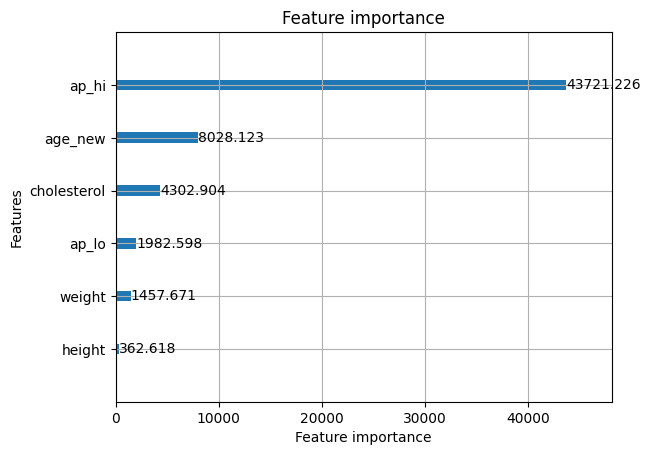

In [27]:
y_pred_prob = model.predict(test.drop(columns=target), num_iteration=model.best_iteration)
y_pred = (y_pred_prob > 0.5).astype(int) 

accuracy = accuracy_score(test[target], y_pred)
print(f'Accuracy на тесте: {accuracy:.4f}')
print(classification_report(test[target], y_pred))

lgb.plot_importance(model, max_num_features=50, importance_type='gain')

y_pred_prob = model.predict(test.drop(columns=target), num_iteration=model.best_iteration)

roc_auc = roc_auc_score(test[target], y_pred_prob)
print(f'ROC-AUC Score на тесте: {roc_auc:.4f}')

In [28]:
roc_auc_train = roc_auc_score(train[target], model.predict(train.drop(columns=target), num_iteration=model.best_iteration))
print(roc_auc_train)

0.8035790016991017


In [29]:
roc_auc_train = roc_auc_score(val[target], model.predict(val.drop(columns=target), num_iteration=model.best_iteration))
print(roc_auc_train)

0.8066255840069471
